# K-Means analysis 

Los datos para este trabajo fueron tomados de la plataforma Kaggle:
https://www.kaggle.com/datasets/nanditapore/credit-risk-analysis?resource=download

## ¿Qué es K-means?
**K-means** es un algoritmo de clustering (agrupamiento) que se utiliza en aprendizaje no supervisado para dividir un conjunto de datos en grupos o clústeres basados en la similitud de sus elementos. El objetivo del algoritmo K-means es particionar los datos en K clústeres de tal manera que cada punto de datos pertenezca al clúster cuyo centroide (punto central) es el más cercano. En resumen, K-means busca encontrar K centroides que minimicen la suma de las distancias cuadradas entre los puntos de datos y sus centroides asignados.

**K-means++**, por otro lado, es una mejora del algoritmo K-means que se utiliza para inicializar los centroides de manera más eficiente y efectiva. En K-means tradicional, la inicialización de los centroides puede ser aleatoria, lo que puede llevar a soluciones subóptimas o convergencia a mínimos locales. K-means++ aborda este problema seleccionando los centroides iniciales de una manera que aumenta las posibilidades de converger a una solución de alta calidad.

Dentro del código de estre trabajo no se especifica de manera explícita que se está trabajando con K-Means++, pero por default sklearn.cluster.KMeans trabaja con la versión optimizada de este método de clustering.

## ¿En qué consiste la información del dataset seleccionado?
La descripción que se proporciona en la plataforma de Kaggle para este set de datos menciona lo siguiente: 
_"This dataset offers a simplified view of the factors that contribute to credit risk, making it an excellent opportunity for data scientists ..."_

## ¿Qué se busca analizar a través del uso de K-Means?
A través del uso de K-Means, se busca analizar y agrupar a los individuos o elementos en categorías o **clústeres que compartan similitudes en sus perfiles de riesgo crediticio**. Esto permitirá una comprensión más profunda de los factores que contribuyen al riesgo crediticio y facilitará la toma de decisiones informadas en el ámbito financiero. Los clústeres obtenidos pueden representar grupos de individuos con características crediticias similares, lo que puede ser útil para segmentar la clientela, identificar tendencias y patrones, y mejorar la gestión de riesgos crediticios.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Cargamos el dataset
df = pd.read_csv('credit_risk.csv')

#Informacion del dataset
print(df.head())
print(df.info())
print(df.describe())

   Id  Age  Income      Home  Emp_length     Intent  Amount   Rate  Status  \
0   0   22   59000      RENT       123.0   PERSONAL   35000  16.02       1   
1   1   21    9600       OWN         5.0  EDUCATION    1000  11.14       0   
2   2   25    9600  MORTGAGE         1.0    MEDICAL    5500  12.87       1   
3   3   23   65500      RENT         4.0    MEDICAL   35000  15.23       1   
4   4   24   54400      RENT         8.0    MEDICAL   35000  14.27       1   

   Percent_income Default  Cred_length  
0            0.59       Y            3  
1            0.10       N            2  
2            0.57       N            3  
3            0.53       N            2  
4            0.55       Y            4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int6

## Visualización de datos

<AxesSubplot:ylabel='Percent_income'>

<Figure size 640x480 with 0 Axes>

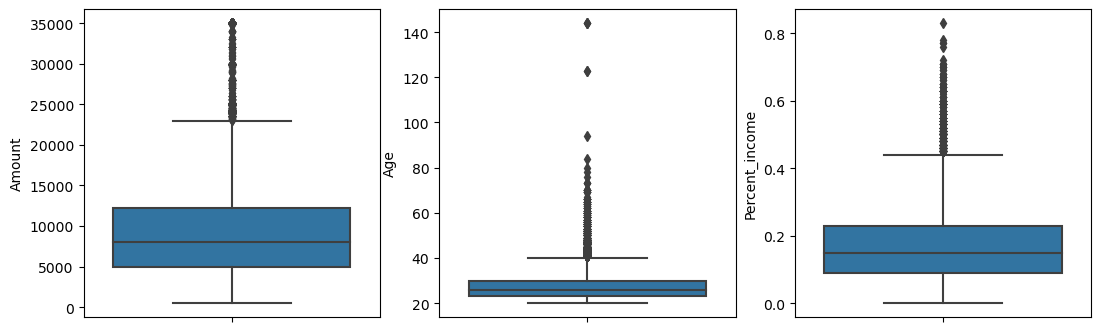

In [3]:
plt.clf()
fig, axs = plt.subplots(1,3, figsize = (13,4))


sns.boxplot(data=df, y = 'Amount', ax = axs[0])
sns.boxplot(data=df, y = 'Age', ax = axs[1])
sns.boxplot(data=df, y = 'Percent_income', ax = axs[2])

<AxesSubplot:xlabel='Default', ylabel='Age'>

<Figure size 640x480 with 0 Axes>

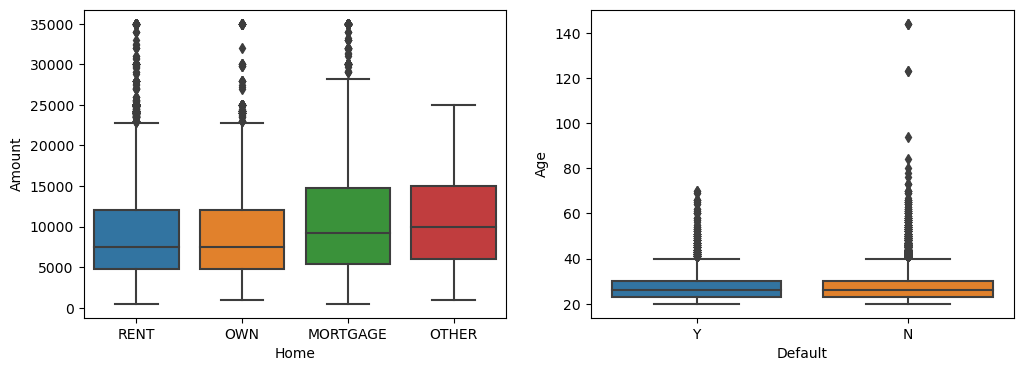

In [4]:
plt.clf()
fig, axs = plt.subplots(1,2, figsize = (12,4))


sns.boxplot(data=df, y = 'Amount', x ='Home', ax = axs[0])
sns.boxplot(data=df, y = 'Age', x = 'Default', ax = axs[1])


<AxesSubplot:xlabel='Intent', ylabel='Rate'>

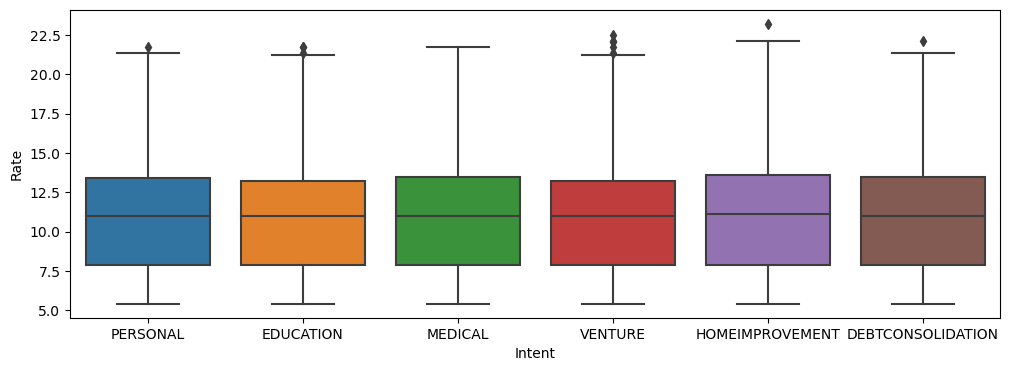

In [5]:
fig = plt.figure(figsize = (12,4))
sns.boxplot(data=df, y = 'Rate', x= 'Intent')

Text(0.5, 1.0, 'Intents by quantity')

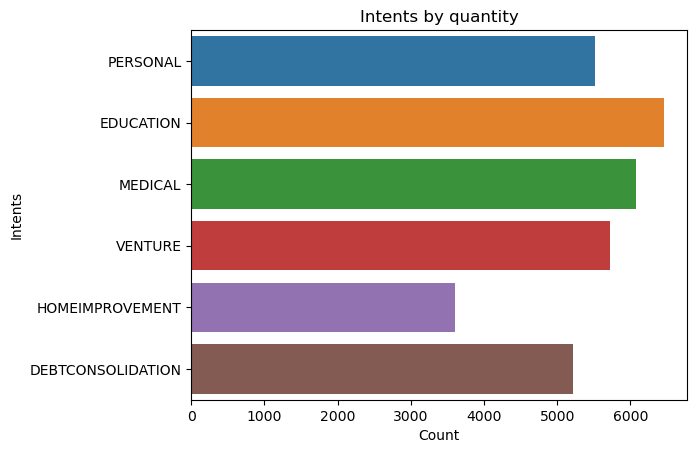

In [6]:
fig = plt.figure()

sns.countplot(data = df, y = 'Intent')

plt.xlabel("Count")
plt.ylabel("Intents")
plt.title("Intents by quantity")

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

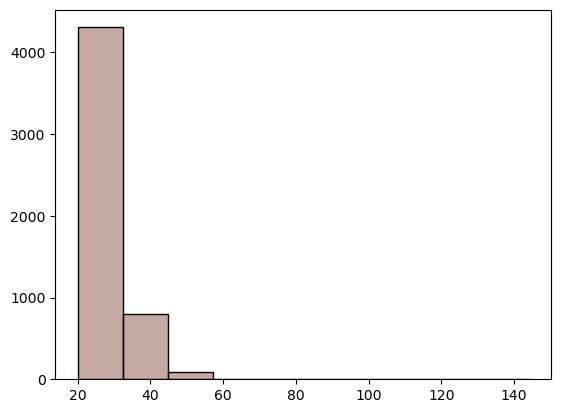

In [7]:
fig = plt.figure()
sns.histplot(data=df, x = 'Age', hue = 'Intent', bins=10, kde=True)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age distribution")

Text(0.5, 1.0, 'Age vs credit length')

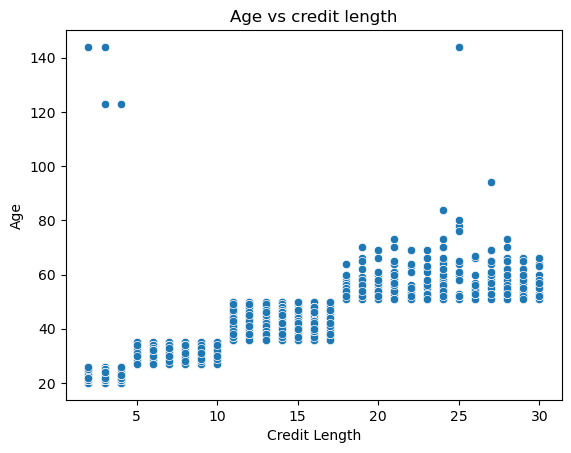

In [8]:
fig = plt.figure()
sns.scatterplot(data=df, x = 'Cred_length', y = 'Age')


plt.xlabel("Credit Length")
plt.ylabel("Age")
plt.title("Age vs credit length")

In [9]:
corr = df.corr()
sns.heatmap(data=corr,cmap='gnuplot', annot = False)

ValueError: could not convert string to float: 'RENT'

## Preparación de los datos

Se normalizan y limpian los datos, para después poder ser utilizados para el modelo de K-Means.

In [10]:
#Variables categoricas a codificar
cat_cols = ['Home', 'Intent', 'Default']
label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Variables numéricas a normalizar
#numeric_cols = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Status', 'Percent_income', 'Cred_length']
#X = df.loc[:, numeric_cols]

scaler = StandardScaler()
X_norm = scaler.fit_transform(df)
X_norm = pd.DataFrame(X_norm, columns=df.columns)

# Remove NaNs
X_norm = X_norm.fillna(0)

## Prueba de K-Means

Se generan distintos modelos de K-Means, variando el número de centroides utilizado. A través de esto logramos visualizar cómo es que se comporta la classificación para disntito número de agrupaciones, y determinar el optimo.

Para ayudar a determinar el desempeño de cada uno de los modelos, dependiendo del número de centroides asignado, se utiliza la métrica sklearn.metrics.silhoutte_score.

### ¿Qué es el 'Silhouette Score' como métrica de sklearn para evaluar K-Means?

El **Silhouette Score** es una métrica utilizada para evaluar la calidad de un agrupamiento (clustering) obtenido mediante algoritmos como K-Means. Proporciona una medida de cuán bien separados están los clústeres y ayuda a determinar la cohesión y separación entre los grupos.

El Silhouette Score se calcula para cada punto de datos y se basa en dos medidas:

1. **a(i)**: La distancia promedio entre el punto de datos i y todos los demás puntos en el mismo clúster. Cuanto menor sea esta distancia, mejor, ya que indica que el punto está más cerca de otros puntos en su mismo clúster.

2. **b(i)**: La distancia promedio entre el punto de datos i y todos los puntos en el clúster más cercano al que no pertenece. Cuanto mayor sea esta distancia, mejor, ya que indica que el punto está más alejado de los puntos en otros clústeres.

El resultado del Silhouette Score varía entre -1 y 1. Cuanto mayor sea el valor, mejor será la calidad del agrupamiento:

- Si el valor es cercano a 1, significa que los clústeres están bien separados y cada punto está cerca de otros puntos en su mismo clúster, lo que indica un buen agrupamiento.
- Si el valor es cercano a 0, indica que los clústeres pueden estar superpuestos y no hay una clara separación.
- Si el valor es cercano a -1, significa que los puntos podrían estar asignados incorrectamente a clústeres y deberían estar en otros grupos.

In [11]:
kmax   = 8 # Número máximo de clusters para los grupos de riesgo
grupos = range(2, kmax)
wcss   = []
sil_score = []

# Ciclo para calcular K-Means para diferentes k
for k in grupos:
    model = KMeans(n_clusters=k, random_state = 30)
    clusters = model.fit_predict(X_norm)
    wcss.append(model.inertia_)
    sil_score.append(silhouette_score(X_norm, clusters))

# Graficar WCSS y Silhouette Score
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Método del codo
axs[0].plot(grupos, wcss)
axs[0].set_title('Método del codo')

# Silhouette Score
axs[1].plot(grupos, sil_score)
axs[1].set_title('Silhouette Score')

/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

KeyboardInterrupt: 

## 'Predicción' o classificación de los datos

A traves de esta sección se busca generar la mejor versión del modelo encontrada en las pruebas pasadas, para facilitar visualizar las relaciones encontradas por el método de machine learning, para poder determinar cuales características definen los distintos perfiles de riesgo crediticio.

In [12]:
model = KMeans(n_clusters=4, random_state=30)
clusters = model.fit_predict(X_norm)

df['Grupo_riesgo'] = clusters.astype('str')
df.head()

/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length,Grupo_riesgo
0,0,22,59000,3,123.0,4,35000,16.02,1,0.59,1,3,1
1,1,21,9600,2,5.0,1,1000,11.14,0,0.10,0,2,3
2,2,25,9600,0,1.0,3,5500,12.87,1,0.57,0,3,1
3,3,23,65500,3,4.0,3,35000,15.23,1,0.53,0,2,1
4,4,24,54400,3,8.0,3,35000,14.27,1,0.55,1,4,1


## Análisis y conclusiones

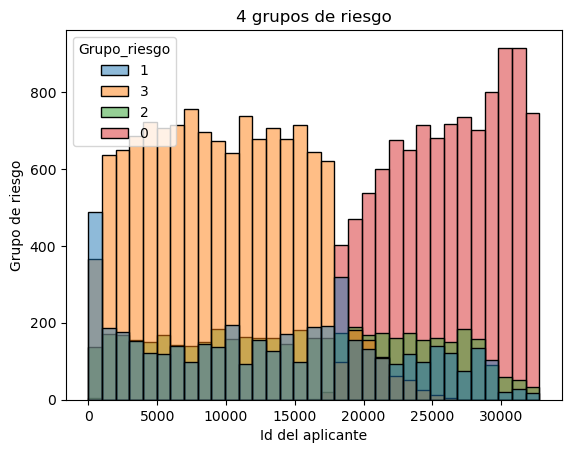

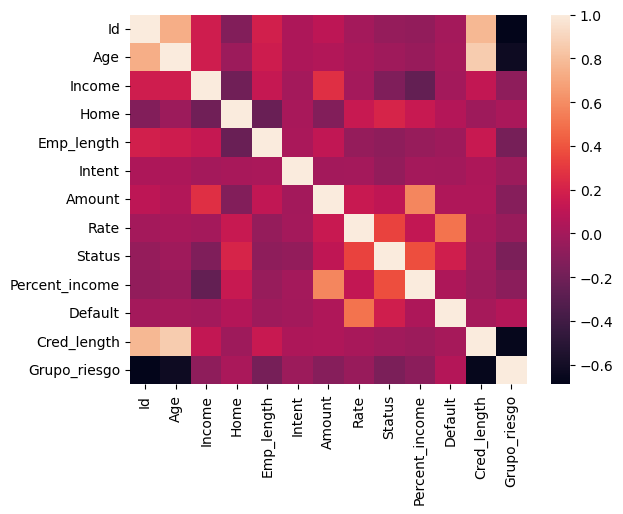

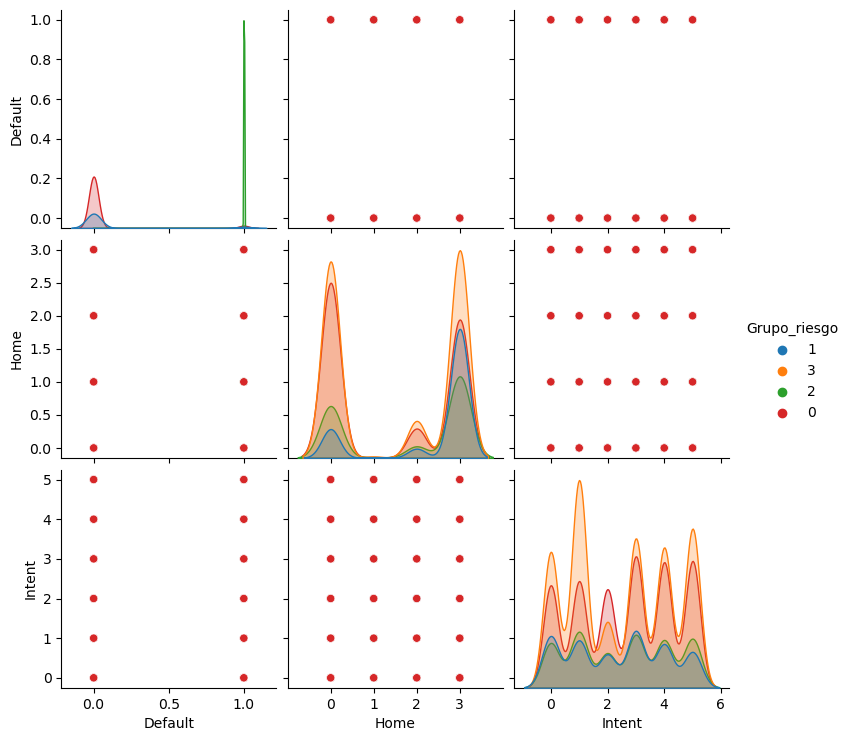

In [13]:
#sns.pairplot(data=df, hue='Grupo_riesgo', palette='tab10')
#plt.suptitle('4 grups de riesgo')

# Gráfico
sns.histplot(data=df, x='Id', hue='Grupo_riesgo', palette='tab10')

# Ejes y título
plt.xlabel('Id del aplicante')
plt.ylabel('Grupo de riesgo')
plt.title('4 grupos de riesgo')
plt.show()

# Coorelación entre variables
# Variables a comparar
vars = ['Age', 'Income', 'Rate', 'Status', 'Percent_income', 'Cred_length']
df_corr = df[vars]
corr = df.corr()
sns.heatmap(data=corr, annot=False)
plt.show()

vars = ['Default', 'Home', 'Intent', 'Grupo_riesgo']
pairplot_data = df[vars]
sns.pairplot(data=pairplot_data, hue='Grupo_riesgo', palette='tab10')
plt.show()